## Lab 5.2 - Using your own images

In the next part of the lab we will download another set of images from the web and format them for use with a Convolutional Neural Network (CNN). In this example we will use cat and dog images from a [recent competition on Kaggle](https://www.kaggle.com/c/dogs-vs-cats) but you will be able to follow the same process to import and format your own sets of images and use them to solve your own image classification problems if you wish.

Let's begin by importing some of the libraries we will be using in this lab:

In [1]:
%matplotlib inline

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import numpy as np
from scipy import misc

import os
import random
import pickle

Go to https://www.kaggle.com/c/dogs-vs-cats/data and download the **"train" dataset only** to your computer. You will have to register for a Kaggle account before you can download the data. [Kaggle](https://www.kaggle.com) is an online repository for Machine Learning (ML) and Artificial Intelligence (AI) competitions and is a great resource for getting data to test your learning algorithms, and to keep up with the state-of-the-art in the ML and AI fields.

Once the `train.zip` file has been downloaded, uncompress it to a folder on your computer. The folder contains 25,000 images named according to whether they are a 'cat' or 'dog'. To make sure that these images work with the code below, create a new folder in the `week-5` folder in your local repository (the same folder that contains this notebook file) called `-catsdogs`. Notice the dash (`-`) before the name, this is important so that Github does not sync the images to your account (which is not necessary and would take a really long time). Within this folder create two new folders called `0` and `1`. Your folder structure should look like this:

    .
    ├── dmc
    |   ├── notebooks
    |   |   └── week-5
    |   |   |   └── -catsdogs
    |   |   |   |   └── 0
    |   |   |   |   └── 1


Finally, move all the cat images into the `0` folder, and all dog images into the `1` folder. From now on, we will consider the category `0` to represent `cat` and the category `1` to represent `dog`.

Next, we will use the `os` library to find the folders inside the main `-catsdogs` folder. This will make the code extensible to image recognition problems with any number of categories. In this case we only have two categories (cats and dogs) but you can extend it to more categories simply by adding more folders with images and labeling the folders sequentially starting with `0`.

In [9]:
imageFolder = "-catsdogs"

folders = os.listdir(imageFolder)
num_categories = len(folders)
folders.remove('.DS_Store')
print folders

['0', '1']


Now we will look through each folder and generate a data set of properly formatted image data matched with the proper category label.

In [10]:
# specify desired image properties
# in this case we want black and white square images 64x64 pixels in size
image_dim = 1 # black and white
image_size = 64

# create an empty array to store the image data
data = []

# look inside each folder which represents the categories of our data
for folder in folders:
    
    # find the files within each folder
    fileNames = os.listdir("/".join([imageFolder, folder]))
    
    # for each file, load and process each image
    # in this case we limit the number of images used per cateogry to 10,000
    # to prevent overloading our RAM memory
    for fileName in fileNames[:10000]:
        
        # read in the image data into a numpy array
        img = misc.imread("/".join([imageFolder, folder, fileName]))
        
        # if the image contains more than one color channel,
        # take only the first channel (in effect, convert it to black and white)
        if image_dim == 1 and len(img.shape) > 2: 
            img = img[:,:,0] # convert to black and white

        # resize to target resolution if necessary
        if img.shape[0] != image_size or img.shape[1] != image_size:
            img = misc.imresize(img, (image_size, image_size), interp='nearest')

        # normalize data to have mean 0 and standard deviation 1
        # then rescale it to roughly the range 0-1
        img = (img - img.mean()) / img.std() / 4 + 0.5
        
        # add the image data and the associated category 
        # (which is stored in the folder variable) to the data set
        # for this to work you need to make sure your folders 
        # are named sequentially starting with 0
        data.append([img, folder])

print "Load data complete"

Load data complete


The process of loading all the image data and putting them into the `data` array will take some time so be patient and wait for the cell to finish running before continuing with the rest of the notebook. 

If you get an error saying the kernel has crashed, you are probably running out of RAM memory. The entire data array with all image information needs to be stored dynamically in your RAM while the process is running, so depending on your computer's available RAM, using too many images or too high of a resolution can cause the RAM to fill up completely before the process has finished running, which will unfortunately cause Python to crash. If you run into this issue try setting a lower target resolution for the images or loading less images from the folder.

Once the data is loaded, we will shuffle the whole dataset to ensure random distribution of both categories.

In [11]:
random.shuffle(data)

Next we will make two new blank numpy arrays for both the feature (X) and target (y) data, and fill them with data from the `data` array. It might seem redundant to first load the data into a Python array and then transfer them to the numpy arrays we actually want. However, Python arrays have a more flexible data structure which allows us to fill the data set without first knowing how many images we have, and lets us keep the feature and target data together for each sample. This makes it easier to shuffle the entire data set in one move, and makes the process more flexible for other sets of images.

In [12]:
X = np.ndarray((len(data), image_size, image_size), dtype=np.float32)
y = np.ndarray((len(data), 1), dtype=np.int32)

for i, d in enumerate(data):
    X[i] = d[0]
    y[i] = d[1]

Let's make sure the data set has been properly imported and formatted by visualizing one of the images in the X feature dataset and printing the corresponding category from the y target dataset.

image dimensions: (64, 64)
target category: dog


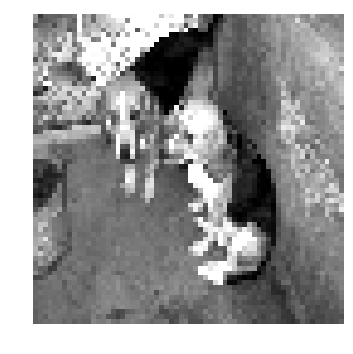

In [13]:
img_index = 2

img = X[img_index]
print "image dimensions:", img.shape
print "target category:", (['cat', 'dog'][y[img_index][0]])

imshow(img, cmap = plt.get_cmap('gray'), vmin = 0, vmax = 1,  interpolation='nearest')
plt.axis('off')
plt.show()

Now we will split both the X and y data sets by an arbitrary factor to create separate training and test sets. As before we will use the first 70% of the data for training, and the remaining 30% of the data for testing.

In [14]:
trainingSplit = int(.7 * X.shape[0])

X_train = X[:trainingSplit]
y_train = y[:trainingSplit]
X_test = X[trainingSplit:]
y_test = y[trainingSplit:]

Finally, we will use the `pickle` library to save these datasets out to a local file. 

The `pickle` library is extremely useful for saving the state of variables in your Python programs for later reuse. The library is able to take variables of any data type and output them to efficiently compressed local binary files. When you need the data again you can use the `pickle` library to reload the variables  from the generated file. This is especially useful for storing sets of data that you may want to reuse several times, but take a long time to produce. This way you won't need to run the process in this notebook each time you want to use the images to train a model.

*Warning:* the saved dataset with 10,000 images per category will be over 300mb, so make sure you have enough space on your hard drive before running the following cell:

In [15]:
pickle_file = imageFolder + '.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {
        'X_train': X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print 'Unable to save data to', pickle_file, ':', e
    raise
    
statinfo = os.stat(pickle_file)
print 'Saved data to', pickle_file
print 'Compressed pickle size:', statinfo.st_size

Unable to save data to -catsdogs.pickle : 


MemoryError: 